# Data
* calcium imaging
* behavior tracking
    * position of male along herm, relative to vulva and tips of herm
    * velocity of male (fwd vs bkwd, absolute vs relative to herm)
    * tail angle
    * spicule position
    * sperm release
* phases of behavior
    * searching: looking for herm, no contact
    * scanning: contact, looking for vulva, male crawls along herm
    * located vulva
    * sperm release ("postsperm" ON to "LtoVulva" increase): insert spicules in vulva, release sperm
    * refractory period: post sperm release


# Plan

* encoding and decoding models
    * which neurons are sensitive to which behavioral variables?
    * which neurons can be used to decode which behavioral variables?
* predicting future activity from current activity
    * latent activity (GCaMP deconvolution, what is known about indicator time constant?)
    * constrained network interactions (chemical and electrical synapses)
    * model activity as a "rate" vs voltage/conductance
    * need to upsample and model continuous time dynamics with discete time observations
    * with and without 
* analysis
    * which neurons are key to which behavioral phases?
    * what is the minimal neural circuit behind each behavioral phase?
    * predict perturbations?
    * neuron/synapse importances?

In [1]:
import os,sys,datetime
os.environ["CUDA_VISIBLE_DEVICES"]="4"

from pathlib import Path
import collections
import numpy as np
import scipy
import pandas as pd
pd.options.display.max_columns=999

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions as dist

In [3]:
import matplotlib.pyplot as plt
# # plt.rcParams['image.cmap'] = 'magma'
plt.rcParams["animation.html"] = "jshtml"
import matplotlib.animation
%matplotlib inline

import seaborn as sns # Used only to set up plots
sns.set_context(context = 'talk')
# sns.set_context(context='paper')
# plt.style.use('dark_background')
# plt.rcParams['figure.facecolor'] = '#272b30'
# plt.rcParams['image.cmap'] = 'viridis' 

In [4]:
#sys.path.append('/groups/turaga/home/turagas/research/')
%load_ext autoreload
%autoreload 2

In [5]:
basepath=Path.home()/'Samuel_Susoy_mating/'

In [6]:
net=pd.read_csv(basepath/'synaptic_partners_v1.csv', skipinitialspace = True, quotechar = '"')
neuron_annot=pd.read_csv(basepath/'transmitters_and_annotations.csv',index_col=0)

In [13]:
# folder = basepath/'normalized_activity_id/'
folder = basepath/'normalized_activity_id_not_filtered/'
files = sorted(list(Path.iterdir(folder)))
data = [pd.read_csv(file,index_col=0) for file in files]
actcols = data[0].columns[:-12]
behcols = data[0].columns[-12:-1]
activity = [d[actcols] for d in data]
behavior = [d[behcols] for d in data]
files = [file.stem for file in files]
dataset_id = [d['dataset'][1] for d in data]

Index(['HOA', 'HOB', 'PVZ', 'PCBL', 'PCCL', 'PCAL', 'SPCL', 'PVY', 'PVX',
       'PVV', 'PHCL', 'PLML', 'PHDL', 'VA10', 'VA11', 'AS11', 'VB11', 'EF1',
       'EF2', 'EF3', 'DVB', 'CP08', 'CA08', 'CA09', 'CP09', 'PVPR', 'R1AL',
       'R1BL', 'R2AL', 'R2BL', 'R6AL', 'R4AL', 'R3AL', 'PHAL', 'SPDL', 'VD13',
       'VD12', 'DB07', 'PDB', 'SPVL', 'VD11', 'DVA', 'VA12', 'DX1', 'DX2',
       'PDC', 'AS10', 'DA07', 'DD06', 'PHBL', 'R8BL', 'R9BL', 'PVPL', 'PVT'],
      dtype='object')


In [8]:
data[0].columns[-13:]

Index(['PVT', 'Velocity', 'Rel.Velocity', 'Speed', 'Rel.Speed', 'TailAngle',
       'LtoTips', 'LtoVul', 'Spicules', 'pos_x', 'pos_y', 'PostSperm',
       'dataset'],
      dtype='object')

In [9]:
activity[0].columns

Index(['HOA', 'HOB', 'PVZ', 'PCBL', 'PCCL', 'PCAL', 'SPCL', 'PVY', 'PVX',
       'PVV', 'PHCL', 'PLML', 'PHDL', 'VA10', 'VA11', 'AS11', 'VB11', 'EF1',
       'EF2', 'EF3', 'DVB', 'CP08', 'CA08', 'CA09', 'CP09', 'PVPR', 'R1AL',
       'R1BL', 'R2AL', 'R2BL', 'R6AL', 'R4AL', 'R3AL', 'PHAL', 'SPDL', 'VD13',
       'VD12', 'DB07', 'PDB', 'SPVL', 'VD11', 'DVA', 'VA12', 'DX1', 'DX2',
       'PDC', 'AS10', 'DA07', 'DD06', 'PHBL', 'R8BL', 'R9BL', 'PVPL', 'PVT'],
      dtype='object')

In [10]:
behavior[0].columns

Index(['Velocity', 'Rel.Velocity', 'Speed', 'Rel.Speed', 'TailAngle',
       'LtoTips', 'LtoVul', 'Spicules', 'pos_x', 'pos_y', 'PostSperm'],
      dtype='object')

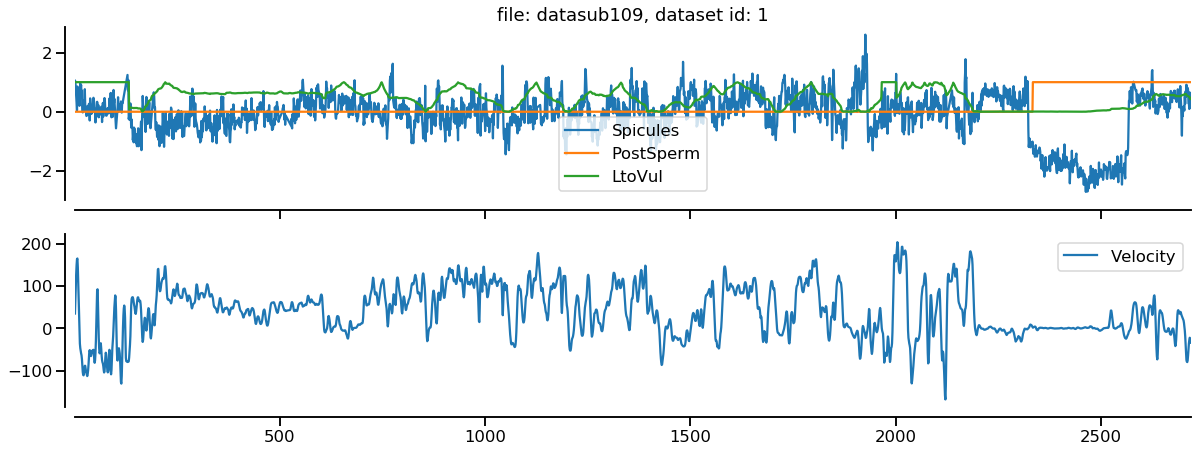

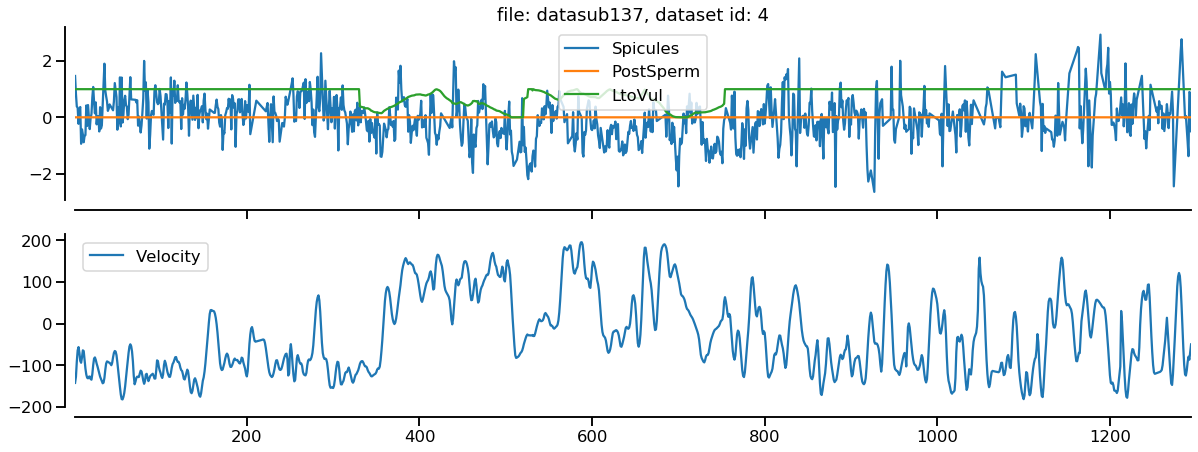

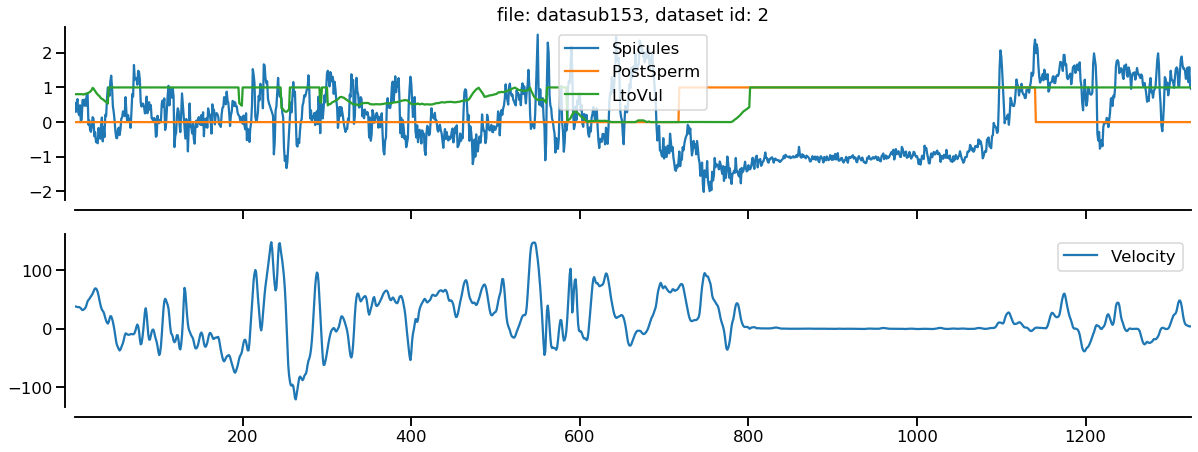

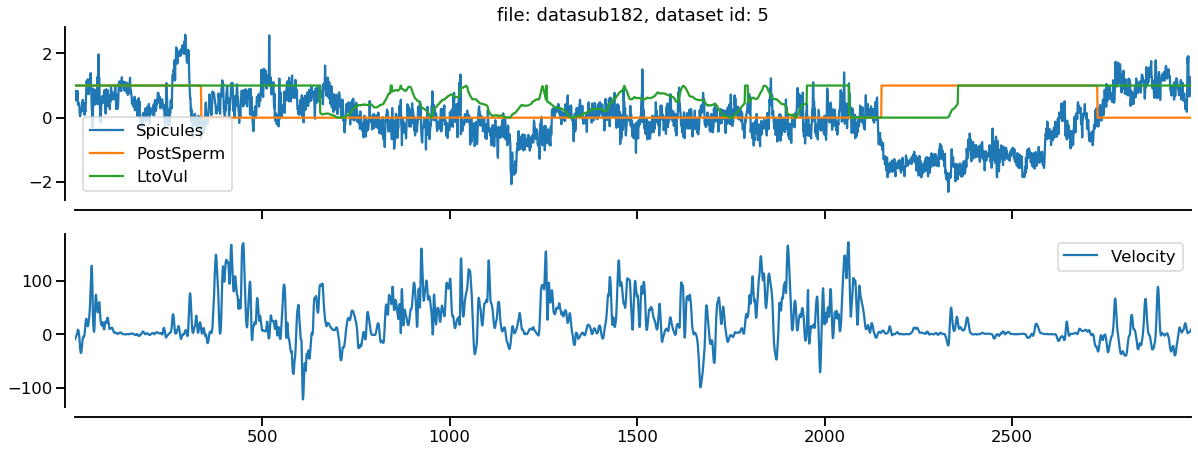

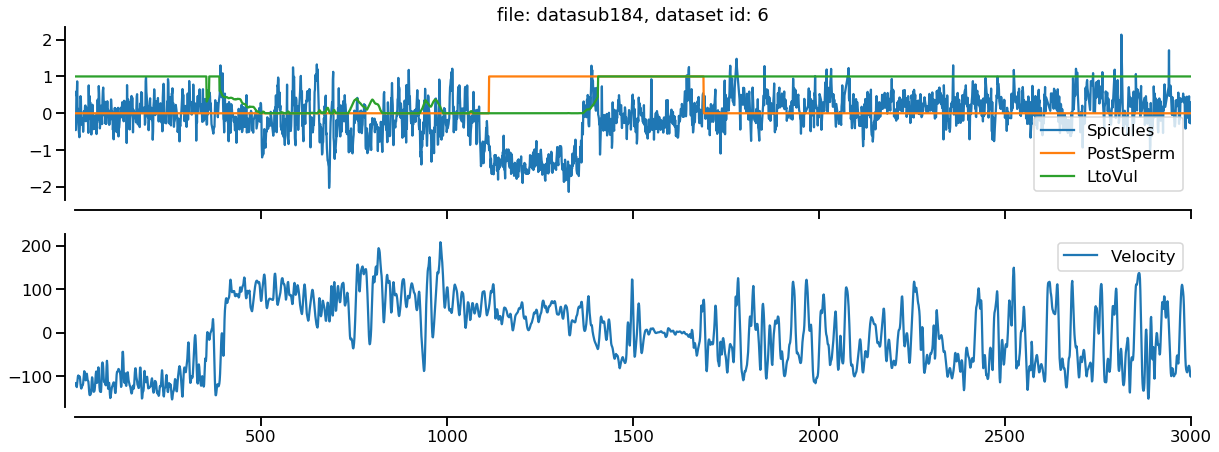

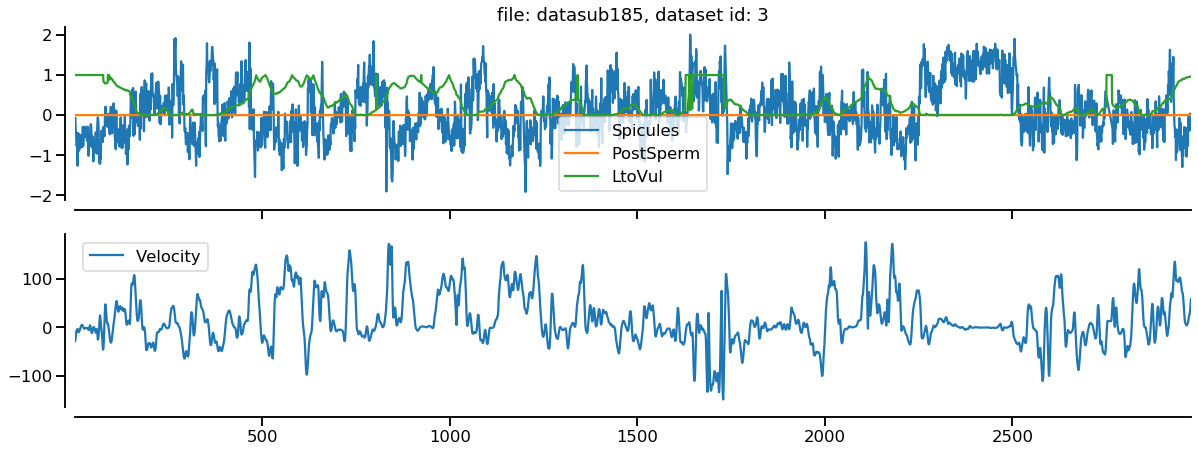

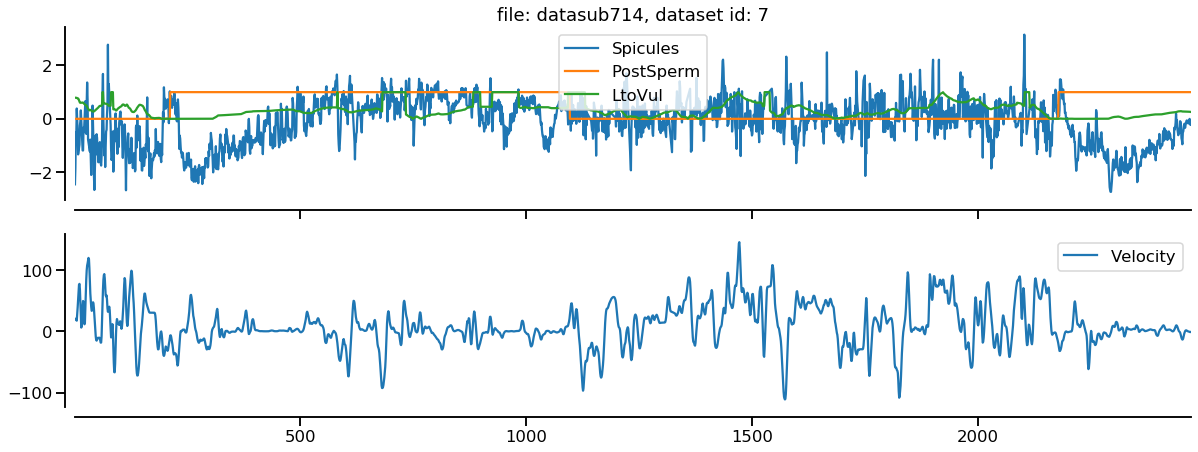

In [11]:
for file,d,d_id in zip(files,data,dataset_id):
    f,axes = plt.subplots(2,1,sharex=True,figsize=(20,7))
    axes[0].set_title('file: {}, dataset id: {}'.format(file,d_id))
    d[['Spicules','PostSperm','LtoVul']].plot(ax=axes[0])
    d[['Velocity']].plot(ax=axes[1])
    sns.despine(offset=10)